In [1]:
# Import packages and set working directory
import os
import numpy as np
import numpy.ma as ma
from glob import glob

import rasterio as rio
import rasterstats as rs
from rasterio.plot import plotting_extent
from rasterio.mask import mask

import pandas as pd
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
from shapely.geometry import mapping, box

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

In [2]:
# This code section processes the vector datasets needed to generate a tree cover score
ph_boundary = gpd.read_file(
    'data/roof-cover/vector/08031/ParkHill.shp')
ph_building = gpd.read_file(
    'data/roof-cover/vector/08031/08031_structure.shp')
sf_boundary = gpd.read_file(
    'data/roof-cover/vector/37119/SherwoodForest.shp')
sf_building = gpd.read_file(
    'data/roof-cover/vector/37119/37119_structure.shp')
state = gpd.read_file(
    "data/spatial-vector-lidar/usa/usa-states-census-2014.shp")
usa = gpd.read_file("data/spatial-vector-lidar/usa/usa-boundary-dissolved.shp")
place = gpd.read_file("data/spatial-vector-lidar/usa/places.shp")
sf_roads = gpd.read_file(
    "data/roof-cover/vector/37119/tl_2018_37119_roads_wgs84.shp")
ph_roads = gpd.read_file(
    "data/roof-cover/vector/08031/tl_2018_08031_roads_wgs84.shp")

# Reproject vector datasets
ph_boundary_utm = ph_boundary.to_crs(epsg=26913)
ph_building_utm = ph_building.to_crs(epsg=26913)
sf_boundary_utm = sf_boundary.to_crs(epsg=26917)
sf_building_utm = sf_building.to_crs(epsg=26917)

# Create subsets for study area map
state_subset = state[state["NAME"].isin(
    ["North Carolina", "Colorado"])]
place_subset = place[place["NAME"].isin(
    ["Charlotte", "Denver"])]

# Create geojson objects for cropping the raster data
sf_geojson = mapping(sf_boundary_utm['geometry'][0])
ph_geojson = mapping(ph_boundary_utm['geometry'][0])

In [3]:
# This code section processes the raster datasets needed for the tree cover analysis
with rio.open("data/roof-cover/raster/37119/m_3508050_se_17_1_20160524.tif") as sf_naip:
    sf_crop_meta = sf_naip.meta
    sf_crop, sf_crop_affine = mask(sf_naip,
                                   [sf_geojson],
                                   crop=True)

with rio.open("data/roof-cover/raster/08031/m_3910417_ne_13_1_20170902.tif") as ph_naip:
    ph_crop_meta = ph_naip.meta
    ph_crop, ph_crop_affine = mask(ph_naip,
                                   [ph_geojson],
                                   crop=True)

# Create spatial plotting extent for the cropped layer
sf_crop_extent = plotting_extent(sf_crop[0], sf_crop_affine)
ph_crop_extent = plotting_extent(ph_crop[0], ph_crop_affine)

# Coerce NAIP data to integer so you can divide without error
ph_crop = ph_crop.astype(int)
sf_crop = sf_crop.astype(int)

# Calculate NDVI for both project areas
ph_ndvi = (ph_crop[3] - ph_crop[0]) / \
    (ph_crop[3] + ph_crop[0])

sf_ndvi = (sf_crop[3] - sf_crop[0]) / \
    (sf_crop[3] + sf_crop[0])

# Define bins, classify and clean the raster data, and update metadata
class_bins = [-1.0, 0.20, np.inf]

ph_ndvi_class = np.digitize(ph_ndvi, class_bins)
sf_ndvi_class = np.digitize(sf_ndvi, class_bins)

ph_ndvi_class_ma = np.ma.masked_where(ph_ndvi_class == 0,
                                      ph_ndvi_class,
                                      copy=True)
sf_ndvi_class_ma = np.ma.masked_where(sf_ndvi_class == 0,
                                      sf_ndvi_class,
                                      copy=True)

ph_ndvi_class_ma = np.float64(ph_ndvi_class_ma)
sf_ndvi_class_ma = np.float64(sf_ndvi_class_ma)

# Update the metadata to be used during the raster export
ph_crop_meta.update({'transform': ph_crop_affine,
                     'height': ph_crop.shape[1],
                     'width': ph_crop.shape[2],
                     'count': 1,
                     'dtype': 'float64',
                     'nodata': -999.99})

sf_crop_meta.update({'transform': sf_crop_affine,
                     'height': sf_crop.shape[1],
                     'width': sf_crop.shape[2],
                     'count': 1,
                     'dtype': 'float64',
                     'nodata': -999.99})

# Output the data as new geotiffs
ph_ma_out = "data/roof-cover/raster/08031/ph_masked.tif"
with rio.open(ph_ma_out, 'w', **ph_crop_meta) as ff:
    ff.write(ph_ndvi_class_ma, 1)

sf_ma_out = "data/roof-cover/raster/37119/sf_masked.tif"
with rio.open(sf_ma_out, 'w', **sf_crop_meta) as ff:
    ff.write(sf_ndvi_class_ma, 1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


In [4]:
# This code section analyzes input raster and vector datasets together and then outputs summary analysis tables
with rio.open('data/roof-cover/raster/08031/ph_masked.tif') as ph_ndvi_src:
    ph_ndvi_data = ph_ndvi_src.read(1, masked=True)
    ph_ndvi_meta = ph_ndvi_src.meta

with rio.open('data/roof-cover/raster/37119/sf_masked.tif') as sf_ndvi_src:
    sf_ndvi_data = sf_ndvi_src.read(1, masked=True)
    sf_ndvi_meta = sf_ndvi_src.meta

# Calculate zonal stats on both study areas
ph_tree_cover = rs.zonal_stats(ph_building_utm,
                               ph_ndvi_data,
                               affine=ph_ndvi_meta['transform'],
                               geojson_out=True,
                               copy_properties=True,
                               nodata=0,
                               stats=['count'],
                               categorical=True)

sf_tree_cover = rs.zonal_stats(sf_building_utm,
                               sf_ndvi_data,
                               affine=sf_ndvi_meta['transform'],
                               geojson_out=True,
                               copy_properties=True,
                               nodata=0,
                               stats=['count'],
                               categorical=True)

# Rename the columns in the geodataframes so they are more meaningful
ph_tree_cover_df = gpd.GeoDataFrame.from_features(ph_tree_cover)
ph_tree_cover_rename = ph_tree_cover_df.rename(
    columns={1.0: 'NonVegCount', 'count': 'TotalCount', 2.0: 'VegCount', 'ExistingLU': 'LandUse'})
ph_tree_cover_rename["PercentVeg"] = ph_tree_cover_rename.VegCount / \
    ph_tree_cover_rename.TotalCount * 100

sf_tree_cover_df = gpd.GeoDataFrame.from_features(sf_tree_cover)
sf_tree_cover_rename = sf_tree_cover_df.rename(
    columns={1.0: 'NonVegCount', 'count': 'TotalCount', 2.0: 'VegCount', 'ExistingLU': 'LandUse'})
sf_tree_cover_rename["PercentVeg"] = sf_tree_cover_rename.VegCount / \
    sf_tree_cover_rename.TotalCount * 100

# Append the geodataframes together
tree_cover_df = ph_tree_cover_rename.append(
    sf_tree_cover_rename, ignore_index=True)
tree_cover_df.index.name = 'RecordID'

# Summarize the dataframe by tree cover, land use, and study area
tree_cover_agg = tree_cover_df.groupby('LandUse').agg(
    ['mean', 'min', 'max', 'count'])['PercentVeg']

study_area_agg = tree_cover_df.groupby('StudyArea').agg(
    ['mean', 'min', 'max', 'count'])['PercentVeg']

sf_building_agg = sf_building.groupby('ExistingLU').agg(
    ['count'])
ph_building_agg = ph_building.groupby('ExistingLU').agg(
    ['count'])

# Output dataframes to csv
tree_cover_df.to_csv("data/roof-cover/outputs/tree_cover.csv")
tree_cover_agg.to_csv("data/roof-cover/outputs/tree_cover_agg.csv")
study_area_agg.to_csv("data/roof-cover/outputs/study_area_agg.csv")
ph_building_agg.to_csv("data/roof-cover/outputs/ph_building_agg.csv")
sf_building_agg.to_csv("data/roof-cover/outputs/sf_building_agg.csv")

# Developing a Tree Cover Score Using Python
**Hans Dumke  -  12/15/2018**

When a natural hazard event hits – whether it is wind, hail, or heavy rain – your home's roof bears the brunt of it.  If your roof fails, the rest of your home can suffer severe damage. These hazard events have a costly effect on roofs across the nation. Because of this risk the roof is viewed by insurance carriers as the most important part of your house according to [Insurance.com].

[Insurance.com]: https://www.insurance.com/home-and-renters-insurance/coverage/have-a-20-year-old-roof-you-may-lose-your-homeowners-insurance.html

Insurance companies go through great lengths to assess the roof condition of the homes they cover. Carriers are looking for more automated ways and data-driven analytics to quickly and accurately assess roof condition and ultimately reduce the need for expensive onsite roof inspections. According to [Claims Journal], "the market is seeing innovation in the inspection process ─ not just more inspections, but smarter, more strategic inspections."  Having detailed property information, such as roof age, presence of skylights, and roof material potentially reduces the need for inspections and could help carriers more quickly determine policy premiums during the underwriting process.

[Claims Journal]:https://www.claimsjournal.com/news/national/2013/08/28/235846.htm

Several data analytics companies, like [Cape Analytics] and [ISO], already offer roof condition ratings for insurers, but these solutions often just rely on past claims history or a limited use of imagery. One characteristic none of the current roof condition solutions seem to consider is tree cover. Tree limbs hanging over a home are a major threat to the roof.  As branches scrape against roof shingles on windy days, they can strip off layers of asphalt, reducing the effectiveness of shingles. Their leaves fall directly onto the roof or into the gutter, which can lead to mold, deterioration, or leaks.  If the tree is damaged or diseased, a storm can cause limbs to fall onto your home. Tree cover should be part of any roof condition analysis.

[Cape Analytics]:https://capeanalytics.com/new-risk-signals-improve-insight-into-roof-claim-potential/

[ISO]:https://www.insurancejournal.com/news/national/2015/08/14/378574.htm

Use of imagery, Python, and  remote sensing techniques can provide a fast, accurate way to answer the tree cover question. This blog will illustrate a simple way to develop a "tree cover score" at a building level using high-resolution, multi-spectral imagery.  The score could be as basic as providing percent of each roof area that is covered by the tree canopy.  The score could then be appended to a parcel or address as part of a larger roof condition rating, which is how the insurance carriers would consume it.

## Acquiring Data Sources

Several different types of data, both raster and vector, are needed for this type of analysis. High resolution, multi-spectral aerial imagery available through the United States Department of Agriculture (USDA) Farm Service Agency National Agriculture Imagery Program (NAIP) program is a good option because it is free, usually leaf-on, and offers the necessary resolution (1m) for this type of analysis. For this proof-of-concept, NAIP imagery was downloaded from [Earth Explorer] website.

[Earth Explorer]: https://earthexplorer.usgs.gov/

Building footprints from [CoreLogic] were chosen because they came pre-attributed with land use and they were available for the study areas.  Other datasets used for the reference maps include TIGER street centerlines and State Boundaries from the United States Census Bureau.

[CoreLogic]: https://www.corelogic.com/products/structure-footprint.aspx


## Choosing the Study Areas

Two study areas were chosen for their contrasting building styles and vegetation cover. The Sherwood Forest neighborhood in the southeastern section of Charlotte, North Carolina is primarily a suburban, single-family residential area with different construction time periods.  Due to its densely-forested nature, one might expect a high degree of tree cover over the buildings in this neighborhood.  Alternately the Park Hill neighborhood of Denver, Colorado is a well-established, urban neighborhood with older but also fewer trees than Sherwood Forest.

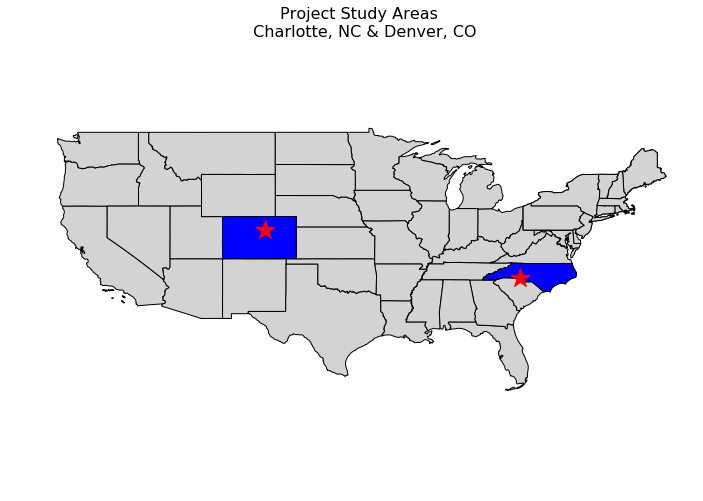

In [5]:
# Plot 1:  Study Area Boundaries
fig, ax = plt.subplots(figsize=(12, 8))

state.plot(alpha=1, color="lightgrey", edgecolor="black", ax=ax)
state_subset.plot(alpha=1, color="blue", edgecolor="black", ax=ax)
place_subset.plot(alpha=1, ax=ax, marker='*', color="red", markersize=400)

ax.set_title('Project Study Areas \n Charlotte, NC & Denver, CO', fontsize=16)
ax.set_axis_off()
plt.axis('equal')

plt.savefig("data/roof-cover/outputs/study_area.png")
plt.show()

### Study Area Characteristics

The Sherwood Forest study area consists of 219 buildings, 86% (189) of which are single family residences (in light green.) A small number of other land uses are clustered along the main arterial through the neighborhood.

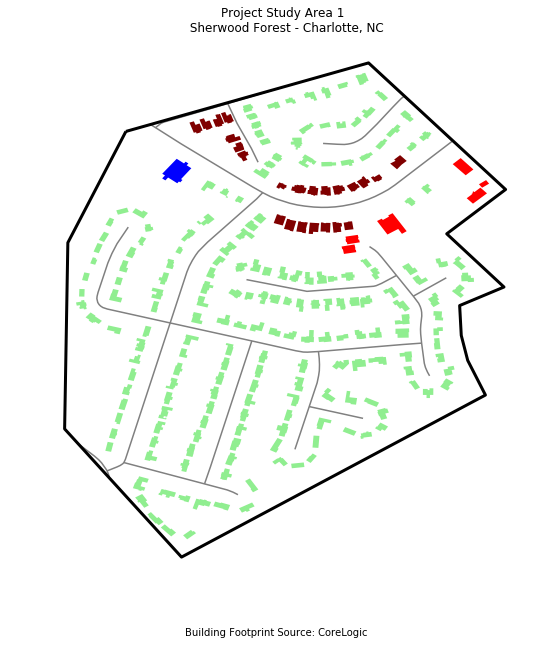

In [6]:
# Plot 2: Detailed Study Area Map of Sherwood Forest
fig, ax = plt.subplots(figsize=(10, 10))

LandUsePalette = {'Civic/Institutional': 'blue',
                  'Single Family - Detached': 'lightgreen',
                  'Commercial': 'red',
                  'Multi Family - Detached': 'maroon'}

for ctype, data in sf_building.groupby('ExistingLU'):
    color = LandUsePalette[ctype]
    data.plot(color=color,
              ax=ax,
              label=ctype)

sf_roads.plot(ax=ax, color='grey')
sf_boundary.boundary.plot(ax=ax, color='black', linewidth=3)

ax.set(title='Project Study Area 1 \n Sherwood Forest - Charlotte, NC')
ax.set_axis_off()

fig.text(.5, .05, "Building Footprint Source: CoreLogic", ha='center')

plt.savefig("data/roof-cover/outputs/sherwood_forest_landuse.png")
plt.show()

The Park Hill study area consists of 142 buildings, 90% (128) of which are single family residences. Similar to Sherwood Forest, the other land uses are clustered along the main arterial (Colfax Ave.) along the south boundary of the neighborhood.

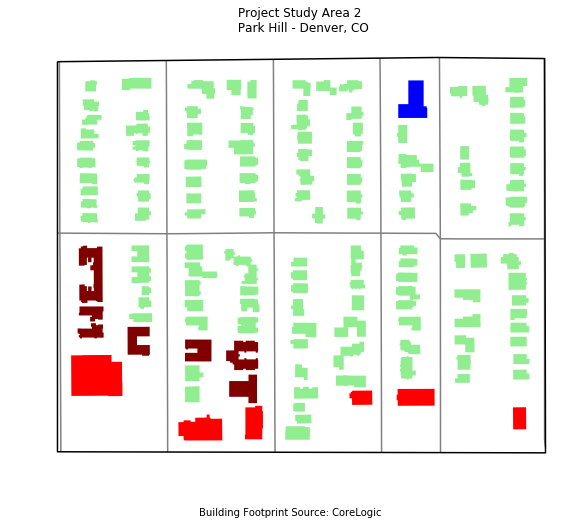

In [7]:
# Plot 3: Detailed Study Area Map of Park Hill
fig, ax = plt.subplots(figsize=(12, 8))

for ctype, data in ph_building.groupby('ExistingLU'):
    color = LandUsePalette[ctype]
    data.plot(color=color,
              ax=ax,
              label=ctype)

ph_roads.plot(ax=ax, color='grey')
ph_boundary.boundary.plot(ax=ax,
                          color='black')

ax.set(title='Project Study Area 2 \n Park Hill - Denver, CO')
ax.set_axis_off()

fig.text(.5, .05, "Building Footprint Source: CoreLogic", ha='center')

plt.savefig("data/roof-cover/outputs/park_hill_landuse.png")
plt.show()

## Defining the Workflow

Once you have the source datasets downloaded and your study area(s) defined, you can begin processing the data using Python. After importing the necessary packages and setting the working directory, the first step would be to load and reproject vector datasets, which would include the building footprints, study area boundaries, and census data. Next you would open and crop the NAIP images using your study area extents.

In order to calculate tree cover you will need to calculate the Normalized Difference Vegetation Index (NDVI), which uses the near infrared (NIR) and red channels from your NAIP images in its formula.  Below are the resulting NDVI images for both study areas.

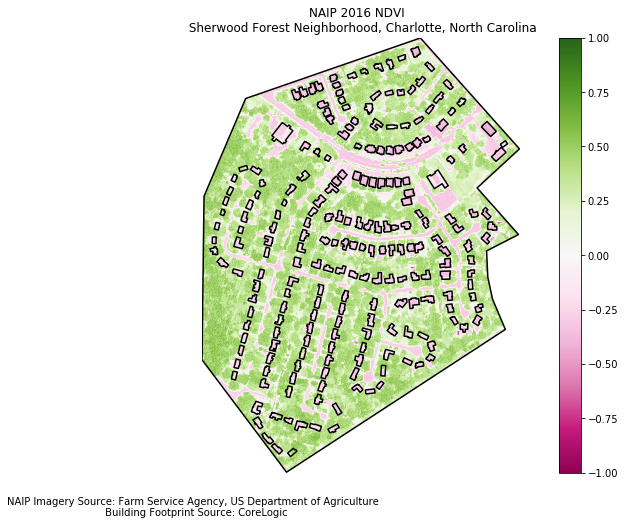

In [8]:
# Plot 4: NDVI Plot for Sherwood Forest
fig, ax = plt.subplots(figsize=(14, 8))

ndvi = ax.imshow(sf_ndvi,
                 cmap='PiYG',
                 extent=sf_crop_extent,
                 vmin=-1, vmax=1)

sf_boundary_utm.boundary.plot(ax=ax,
                              color='black')
sf_building_utm.boundary.plot(ax=ax,
                              color='black')

# Code to add color bar, title, and caption
fig.colorbar(ndvi, fraction=.05)
fig.text(.5, .05, "NAIP Imagery Source: Farm Service Agency, US Department of Agriculture \n Building Footprint Source: CoreLogic", ha='center')
ax.set(title="NAIP 2016 NDVI  \n Sherwood Forest Neighborhood, Charlotte, North Carolina")
ax.set_axis_off()

plt.savefig("data/roof-cover/outputs/sherwood_forest_ndvi.png")
plt.show()

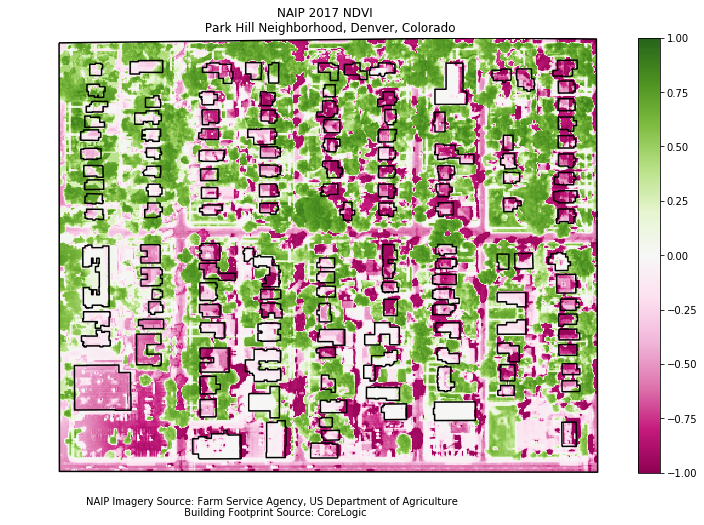

In [9]:
# Plot 5: NDVI Plot for Park Hill
fig, ax = plt.subplots(figsize=(14, 8))

ndvi = ax.imshow(ph_ndvi,
                 cmap='PiYG',
                 extent=ph_crop_extent,
                 vmin=-1, vmax=1)

ph_boundary_utm.boundary.plot(ax=ax,
                              color='black')
ph_building_utm.boundary.plot(ax=ax,
                              color='black')

# Code to add color bar, title, and caption
fig.colorbar(ndvi, fraction=.05)
fig.text(.5, .05, "NAIP Imagery Source: Farm Service Agency, US Department of Agriculture \n Building Footprint Source: CoreLogic", ha='center')
ax.set(title="NAIP 2017 NDVI  \n Park Hill Neighborhood, Denver, Colorado")
ax.set_axis_off()

plt.savefig("data/roof-cover/outputs/park_hill_ndvi.png")
plt.show()

In order to simplify the calculation of the tree cover score, the NDVI rasters can be reclassified to fewer bins. NDVI thresholds (is this healthy vegetation versus something else?) can vary depending on season, locale, atmospheric conditions, soil types, and humidity.  To determine the accurate range of NDVI for these study areas, different threshold values were tested and visually checked.  A threshold of 0.2 was chosen as the best indicator for this analysis but that number may vary depending on study area and image source.  Below is an example of the resulting reclassified and cleaned image for the Park Hill study area.

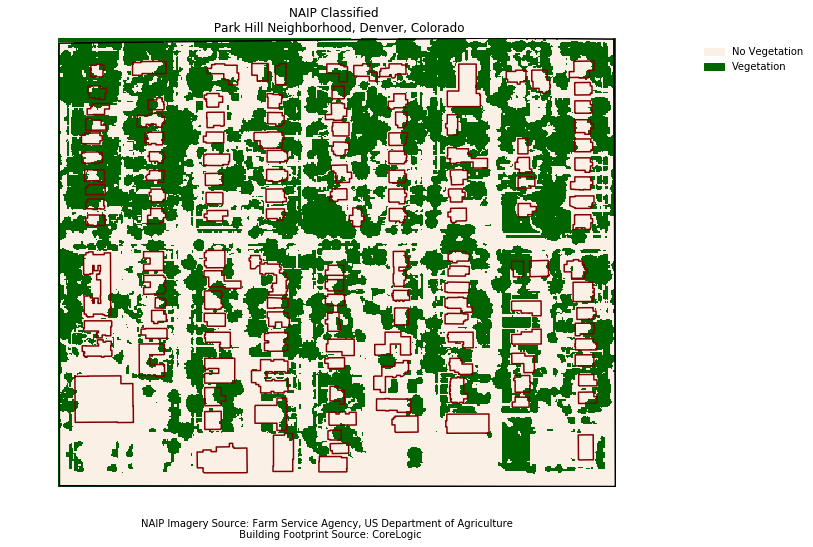

In [10]:
# Plot 6: Park Hill Classified
colors = ['linen', 'darkgreen']

ph_class_labels = ["No Vegetation", "Vegetation"]
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(colors, ph_class_labels)]

cmap = ListedColormap(colors)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(ph_ndvi_class_ma,
          cmap=cmap,
          extent=ph_crop_extent)

ph_boundary_utm.boundary.plot(ax=ax,
                              color='black')
ph_building_utm.boundary.plot(ax=ax,
                              color='maroon')

ax.legend(handles=legend_patches,
          facecolor="white",
          edgecolor="white",
          bbox_to_anchor=(1.35, 1))

ax.set(title="NAIP Classified  \n Park Hill Neighborhood, Denver, Colorado")
fig.text(.5, .12, "NAIP Imagery Source: Farm Service Agency, US Department of Agriculture \n Building Footprint Source: CoreLogic", ha='center')

ax.set_axis_off()
plt.savefig("data/roof-cover/outputs/park_hill_classified.png")
plt.show()

Once the input raster and vector datasets have been processed, you can finally run your calculations to assess tree cover at the building level.  To do this you will use zonal statistics from the rasterstats package to calculate a percent tree cover for each building in each of the study areas.  Finally, you can aggregate and output the results to a table which could then be joined back up to a shapefile or appended to a database containing other roof condition characteristics.

## Analyzing the Results

### Is Location Important?
Once might expect the Sherwood Forest study area to have a higher tree cover score based on its histogram of NDVI pixel distribution below.  The neighborhood does indeed have a larger number of values in the higher spectrum than Park Hill, which exhibits a more even distribution of NDVI values.

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


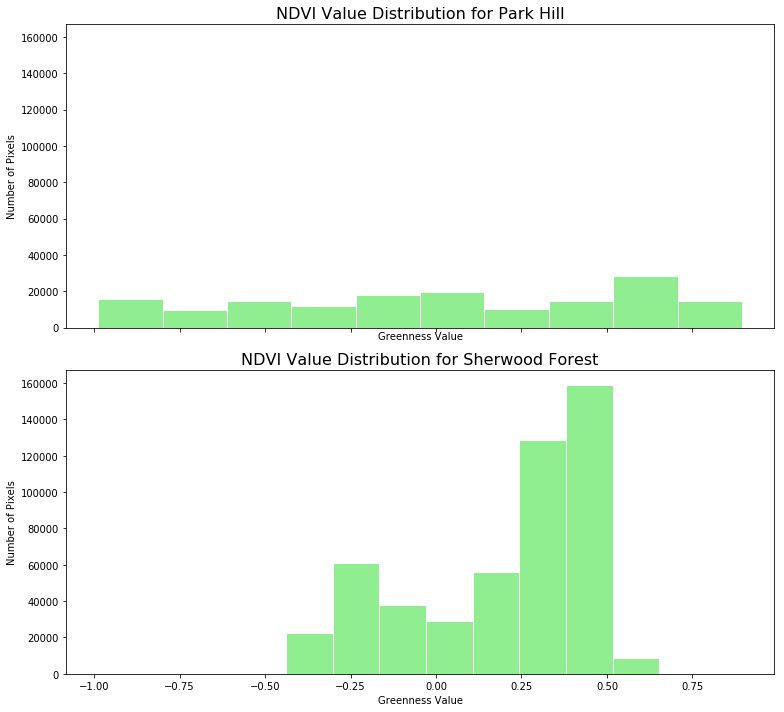

In [11]:
# Plot 7: NDVI raster histograms for both study areas
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(11, 10), sharex=True, sharey=True)
ax1.hist(ph_ndvi.ravel(),
         color='lightgreen',
         edgecolor='white')
ax1.set_title("NDVI Value Distribution for Park Hill", fontsize=16)
ax1.set(xlabel="Greenness Value",
        ylabel="Number of Pixels")

ax2.hist(sf_ndvi.ravel(),
         color='lightgreen',
         edgecolor='white')
ax2.set_title("NDVI Value Distribution for Sherwood Forest", fontsize=16)
ax2.set(xlabel="Greenness Value",
        ylabel="Number of Pixels")

plt.savefig("data/roof-cover/outputs/ndvi_comparison.png")
plt.tight_layout()
plt.show()

However after aggregating the building level results for each study area, Park Hill actually has a slightly higher mean tree cover score than Sherwood Forest.  This could be a result of the fact that Park Hill is an older neighborhood with an older, larger deciduous tree canopy.  Sherwood Forest is a newer development and has slightly more coniferous vegetation which does not spread out as much as deciduous vegetation. More study areas with varying building types and vegetation should be selected to further understand how location affects tree cover.

In [12]:
study_area_agg

,mean,min,max,count
StudyArea,,,,
Park Hill,17.233982,0.198020,98.290598,115
Sherwood Forest,15.585421,0.155763,84.615385,180


### How Does Land Use Affect Tree Cover Score?

Looking more closely at how land use might affect tree cover score, the results for both study areas are in line with one might expect.  The mean tree cover score of 17.06 for single family residential buildings indicates that this land use category is at higher risk for tree-related roof issues than other land use categories. This is an important fact that illustrates that we should focus on single family residences when we move forward with calculation of a nationwide tree cover score. 

In [13]:
tree_cover_agg

,mean,min,max,count
LandUse,,,,
Civic/Institutional,0.320993,0.155763,0.486224,2
Commercial,1.615210,0.198020,4.291845,5
Multi Family - Detached,8.095527,0.420168,45.000000,15
Single Family - Detached,17.059094,0.297619,98.290598,273


### Does Size Really Matter?

One might expect that a larger building size would be less susceptible to high tree cover.  For example a mansion or large commercial building is likely to have a large enough footprint that it would not have a high percent tree cover.  Similar to land use, filtering on buildings over x size would improve efficiency and cost on a nationwide calculation.  However at least based on these two study areas, which are primarily single family, it's difficult to discern whether there a high correlation between large size and tree cover score.  One would need to pick additional study areas with larger buildings before being able to make that determination.

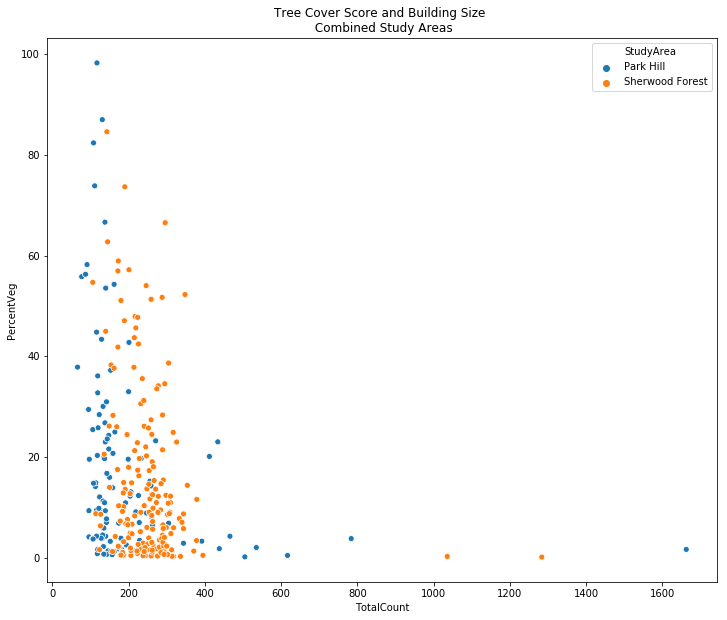

In [14]:
# Plot 8: scatter plot building size compared to tree cover
fig, ax = plt.subplots(figsize=(12, 10))

plt.setp(ax1.get_xticklabels(), rotation=45)

ax.set(title="Tree Cover Score and Building Size \n Combined Study Areas")

sns.scatterplot(x='TotalCount', y='PercentVeg', data=tree_cover_df,
                hue='StudyArea')

plt.savefig("data/roof-cover/outputs/percent_veg_and_building_size.png")
plt.show()

## Conclusions and Areas for Future Research

NAIP imagery will certainly work for this type of analysis, but a tree cover score based on percent tree cover and NAIP imagery will only be a crude indicator of risk. The vintage of the NAIP imagery could become an issue, particularly in fast-growing areas with new developments. There are also potential issues with detecting trees in shadows and leaf on versus leaf off conditions, which remains a major drawback of this approach.

Source, vintage, and spatial accuracy of the footprints should be carefully considered as this also will affect accuracy of the tree cover score. There are commercially available imagery providers and hyperspectral imagery that may be more current and may better align to your building footprints.

Location was not as much of a factor in tree cover scores as expected with these two study areas. However one would want to pick additional study areas with different vegetation and construction patterns to confirm exactly how geography might affect tree cover score.

Single family buildings are most affected by tree cover so any nationwide analysis could just filter on those building types which would save processing time and money.

Building size does not seem to affect percent tree cover either but further analysis using study areas with a higher distribution of large buildings is recommended.

Finally, we did not validate the results of our tree cover analysis against other sources.  One could create a hand-labeled dataset, perform field research, or use of an existing tree cover dataset to confirm the accuracy of the score. Additionally use of insurance claims related to tree damage would also validate the applicability of this score.